# Part1

In [77]:
# Import libraries
import tqdm
import torch
import torchvision

import numpy as np
import torch.nn as nn
import seaborn as sns
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as transforms

from sklearn.metrics import confusion_matrix

In [ ]:
# Define the transformation
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Load CIFAR-10
train_set = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform)


# Split the dataset into train, validation sests
train_size = 40000
val_size = 10000

train_dataset, val_dataset = torch.utils.data.random_split(
    train_set, [train_size, val_size])


# Create data loaders
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False)

In [20]:
# Function to show a random image from each class
def plot_images(loader, dataset):

    # Get the classes names
    classes = dataset.classes

    # Get the a batch of the loader
    images, labels = next(iter(loader))

    # Plot one random image from each class
    fig, axs = plt.subplots(2, 5, figsize=(10, 5))
    fig.suptitle('Random Images from Each Class')

    for i in range(10):
        class_indices = (labels == i).nonzero().flatten()
        random_index = class_indices[np.random.randint(
            len(class_indices))]

        image = images[random_index].numpy()
        image = np.transpose(image, (1, 2, 0))
        mean = np.array([0.5, 0.5, 0.5])
        std = np.array([0.5, 0.5, 0.5])
        image = std * image + mean
        image = np.clip(image, 0, 1)

        axs[i // 5, i % 5].imshow(image)
        axs[i // 5, i % 5].set_title(classes[i])
        axs[i // 5, i % 5].axis('off')

    plt.show()

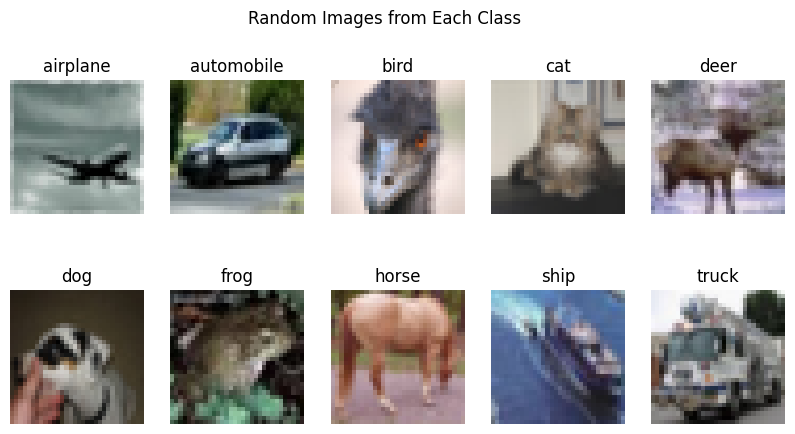

In [21]:
# Plot random images from each class
plot_images(train_loader, train_set)

# Part 2

In [23]:
# Train function
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for inputs, labels in tqdm.tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    accuracy = correct_predictions / total_samples

    return running_loss / len(train_loader), accuracy

In [ ]:
# Validation function
def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    validation_loss = running_loss / len(val_loader)
    accuracy = correct_predictions / total_samples

    return validation_loss, accuracy

In [31]:
# Test function
def test(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    test_loss = running_loss / len(test_loader)
    accuracy = correct_predictions / total_samples

    return test_loss, accuracy

In [24]:
class BaselineModel(nn.Module):
      def __init__(self):
          super(BaselineModel, self).__init__()
          self.conv1 = nn.Conv2d(
              in_channels=3, out_channels=32, kernel_size=5)
          self.relu = nn.ReLU()
          self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
          self.flatten = nn.Flatten()
          self.fc = nn.Linear(32 * 14 * 14, 10)

      def forward(self, x):
          x = self.conv1(x)
          x = self.relu(x)
          x = self.maxpool(x)
          x = self.flatten(x)
          x = self.fc(x)
          return x

In [25]:
# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model, loss function, and optimizer
baseline_model = BaselineModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(baseline_model.parameters(), lr=0.001)

In [26]:
# Set worst loss for save the best model
best_val_loss = float('inf')
best_epoch = -1

# Save per epochs stats for plot
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Set number of epochs
num_epochs = 20

# Loop through the epochs
for epoch in range(num_epochs):

    # train the model
    train_loss, train_accuracy = train(
        baseline_model, train_loader, criterion, optimizer, device)

    # validate the model
    val_loss, val_accuracy = validate(
        baseline_model, val_loader, criterion, device)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch + 1}/{num_epochs} || "
          f"Train Loss: {train_loss:.4f}, "
          f"Train Accuracy: {train_accuracy * 100:.2f}%, "
          f"Validation Loss: {val_loss:.4f}, "
          f"Validation Accuracy: {val_accuracy * 100:.2f}%")

    # Save the best model based on validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
        best_model_state = baseline_model.state_dict()

100%|██████████| 625/625 [00:12<00:00, 49.10it/s]


Epoch 1/20 || Train Loss: 1.4377, Train Accuracy: 49.55%, Validation Loss: 1.2173, Validation Accuracy: 57.14%


100%|██████████| 625/625 [00:12<00:00, 49.76it/s]


Epoch 2/20 || Train Loss: 1.1287, Train Accuracy: 60.95%, Validation Loss: 1.1486, Validation Accuracy: 60.03%


100%|██████████| 625/625 [00:12<00:00, 50.70it/s]


Epoch 3/20 || Train Loss: 1.0212, Train Accuracy: 65.00%, Validation Loss: 1.0765, Validation Accuracy: 62.84%


100%|██████████| 625/625 [00:15<00:00, 39.28it/s]


Epoch 4/20 || Train Loss: 0.9624, Train Accuracy: 66.93%, Validation Loss: 1.0757, Validation Accuracy: 62.89%


100%|██████████| 625/625 [00:18<00:00, 33.26it/s]


Epoch 5/20 || Train Loss: 0.9192, Train Accuracy: 68.59%, Validation Loss: 1.0621, Validation Accuracy: 64.22%


100%|██████████| 625/625 [00:15<00:00, 41.43it/s]


Epoch 6/20 || Train Loss: 0.8773, Train Accuracy: 70.01%, Validation Loss: 1.0232, Validation Accuracy: 65.31%


100%|██████████| 625/625 [00:13<00:00, 46.82it/s]


Epoch 7/20 || Train Loss: 0.8404, Train Accuracy: 71.13%, Validation Loss: 1.0721, Validation Accuracy: 63.59%


100%|██████████| 625/625 [00:11<00:00, 54.84it/s]


Epoch 8/20 || Train Loss: 0.8095, Train Accuracy: 72.05%, Validation Loss: 1.0483, Validation Accuracy: 65.10%


100%|██████████| 625/625 [00:12<00:00, 50.53it/s]


Epoch 9/20 || Train Loss: 0.7906, Train Accuracy: 72.89%, Validation Loss: 1.0741, Validation Accuracy: 63.83%


100%|██████████| 625/625 [00:11<00:00, 54.80it/s]


Epoch 10/20 || Train Loss: 0.7607, Train Accuracy: 73.74%, Validation Loss: 1.0840, Validation Accuracy: 63.96%


100%|██████████| 625/625 [00:11<00:00, 52.94it/s]


Epoch 11/20 || Train Loss: 0.7373, Train Accuracy: 74.70%, Validation Loss: 1.0812, Validation Accuracy: 64.40%


100%|██████████| 625/625 [00:12<00:00, 51.81it/s]


Epoch 12/20 || Train Loss: 0.7207, Train Accuracy: 75.29%, Validation Loss: 1.1324, Validation Accuracy: 63.20%


100%|██████████| 625/625 [00:11<00:00, 53.18it/s]


Epoch 13/20 || Train Loss: 0.6936, Train Accuracy: 76.06%, Validation Loss: 1.1253, Validation Accuracy: 64.11%


100%|██████████| 625/625 [00:14<00:00, 43.44it/s]


Epoch 14/20 || Train Loss: 0.6785, Train Accuracy: 76.67%, Validation Loss: 1.0981, Validation Accuracy: 64.94%


100%|██████████| 625/625 [00:11<00:00, 54.65it/s]


Epoch 15/20 || Train Loss: 0.6530, Train Accuracy: 77.63%, Validation Loss: 1.1061, Validation Accuracy: 65.44%


100%|██████████| 625/625 [00:12<00:00, 50.81it/s]


Epoch 16/20 || Train Loss: 0.6350, Train Accuracy: 78.14%, Validation Loss: 1.1484, Validation Accuracy: 64.05%


100%|██████████| 625/625 [00:11<00:00, 53.61it/s]


Epoch 17/20 || Train Loss: 0.6206, Train Accuracy: 78.68%, Validation Loss: 1.1593, Validation Accuracy: 64.95%


100%|██████████| 625/625 [00:12<00:00, 50.92it/s]


Epoch 18/20 || Train Loss: 0.6075, Train Accuracy: 79.02%, Validation Loss: 1.1919, Validation Accuracy: 63.55%


100%|██████████| 625/625 [00:12<00:00, 50.46it/s]


Epoch 19/20 || Train Loss: 0.5879, Train Accuracy: 79.81%, Validation Loss: 1.1759, Validation Accuracy: 64.08%


100%|██████████| 625/625 [00:11<00:00, 54.14it/s]


Epoch 20/20 || Train Loss: 0.5738, Train Accuracy: 80.02%, Validation Loss: 1.1936, Validation Accuracy: 64.10%


In [30]:
# Save the best model
torch.save(best_model_state, 'best_baseline_model.pth')
print(f'Best model saved in epoch {best_epoch + 1}')

# Save loss and accuracy values in train_history dict for plot
train_history = {
    'train_loss': train_losses, 'train_accuracy': train_accuracies,
    'val_loss': val_losses, 'val_accuracy': val_accuracies}

Best model saved in epoch 6


In [28]:
# A function for plot the loss and accs for each epoch
def plot_training_history(train_history):
    epochs = range(1, len(train_history['train_loss']) + 1)
    # Plot Loss
    plt.figure(figsize=(8, 3))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_history['train_loss'], label='Training Loss')
    plt.plot(epochs, train_history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_history['train_accuracy'],
             label='Training Accuracy')

    plt.plot(epochs, train_history['val_accuracy'],
             label='Validation Accuracy')

    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

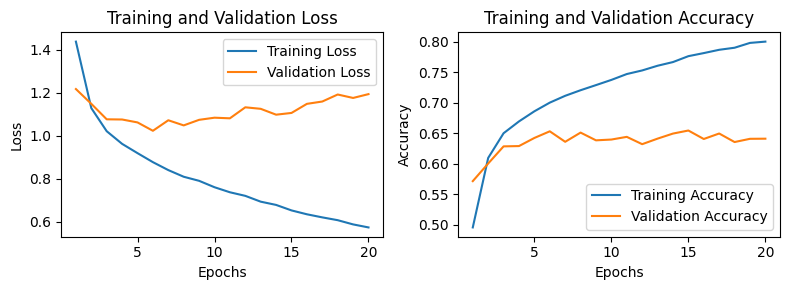

In [29]:
# Apply the function and plot the history
plot_training_history(train_history)

In [33]:
#Load the best model
best_model = BaselineModel()
best_model.load_state_dict(torch.load('best_baseline_model.pth'))
best_model.to(device)

# Test the best model on the testset
test_loss, test_accuracy = test(
    best_model, test_loader, criterion, device)

# Print the test performances
print(f"Test Loss: {test_loss:.4f},"
      f"Test Accuracy: {test_accuracy * 100:.2f}%")

Test Loss: 1.2171,Test Accuracy: 63.32%


##### Part2 Summary: In this part I trained the baseline model for 20 epochs. The best model is selected based on validation loss (in 6th epoch). The best model performance is mentioned below.
 -  Train Accuracy: 70.01%
 -  Validaton Accuracy: 65.31%
 -  Test Accuracy: 63.32%

 -  Train Loss: 0.8773
 -  Validation Loss: 1.0232
 - Test Loss: 1.2171

##### The best model is saved as "best_baseline_model.pth"


# Part3

In [53]:
# Improve the baseline model

class ThirdPartModel(nn.Module):
      def __init__(self):
          super(ThirdPartModel, self).__init__()
          self.conv1 = nn.Conv2d(
              in_channels=3, out_channels=32, kernel_size=5)
          self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
          self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
          self.relu = nn.ReLU()
          self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
          self.flatten = nn.Flatten()
          self.fc1 = nn.Linear(128*2*2, 256)
          self.fc2 = nn.Linear(256, 10)

      def forward(self, x):
          x = self.conv1(x)
          x = self.relu(x)
          x = self.maxpool(x)

          x = self.conv2(x)
          x = self.relu(x)
          x = self.maxpool(x)

          x = self.conv3(x)
          x = self.relu(x)
          x = self.maxpool(x)

          x = self.flatten(x)
          x = self.fc1(x)
          x = self.relu(x)
          x = self.fc2(x)

          return x

In [54]:
# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model, loss function, and optimizer
third_part_model = ThirdPartModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(third_part_model.parameters(), lr=0.001)

In [55]:
# Set worst loss for save the best model
best_val_loss = float('inf')
best_epoch = -1

# Save per epochs stats for plot
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Set number of epochs
num_epochs = 20

# Loop through the epochs
for epoch in range(num_epochs):

    # train the model
    train_loss, train_accuracy = train(
        third_part_model, train_loader, criterion, optimizer, device)

    # validate the model
    val_loss, val_accuracy = validate(
        third_part_model, val_loader, criterion, device)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Print stats
    print(f"Epoch {epoch + 1}/{num_epochs} || "
          f"Train Loss: {train_loss:.4f}, "
          f"Train Accuracy: {train_accuracy * 100:.2f}%, "
          f"Validation Loss: {val_loss:.4f}, "
          f"Validation Accuracy: {val_accuracy * 100:.2f}%")

    # Save the best model based on validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
        best_model_state = third_part_model.state_dict()

100%|██████████| 625/625 [00:12<00:00, 49.08it/s]


Epoch 1/20 || Train Loss: 1.5541, Train Accuracy: 42.80%, Validation Loss: 1.2688, Validation Accuracy: 54.03%


100%|██████████| 625/625 [00:13<00:00, 47.78it/s]


Epoch 2/20 || Train Loss: 1.1742, Train Accuracy: 58.05%, Validation Loss: 1.1009, Validation Accuracy: 61.60%


100%|██████████| 625/625 [00:17<00:00, 36.40it/s]


Epoch 3/20 || Train Loss: 0.9895, Train Accuracy: 64.95%, Validation Loss: 0.9831, Validation Accuracy: 65.69%


100%|██████████| 625/625 [00:18<00:00, 33.36it/s]


Epoch 4/20 || Train Loss: 0.8548, Train Accuracy: 69.77%, Validation Loss: 0.9072, Validation Accuracy: 68.30%


100%|██████████| 625/625 [00:14<00:00, 44.16it/s]


Epoch 5/20 || Train Loss: 0.7509, Train Accuracy: 73.57%, Validation Loss: 0.8534, Validation Accuracy: 70.15%


100%|██████████| 625/625 [00:13<00:00, 47.20it/s]


Epoch 6/20 || Train Loss: 0.6582, Train Accuracy: 76.92%, Validation Loss: 0.8679, Validation Accuracy: 70.17%


100%|██████████| 625/625 [00:13<00:00, 47.98it/s]


Epoch 7/20 || Train Loss: 0.5794, Train Accuracy: 79.47%, Validation Loss: 0.8243, Validation Accuracy: 71.98%


100%|██████████| 625/625 [00:13<00:00, 47.74it/s]


Epoch 8/20 || Train Loss: 0.5120, Train Accuracy: 81.93%, Validation Loss: 0.8917, Validation Accuracy: 71.29%


100%|██████████| 625/625 [00:14<00:00, 42.15it/s]


Epoch 9/20 || Train Loss: 0.4440, Train Accuracy: 84.29%, Validation Loss: 0.8879, Validation Accuracy: 71.74%


100%|██████████| 625/625 [00:13<00:00, 48.04it/s]


Epoch 10/20 || Train Loss: 0.3918, Train Accuracy: 86.11%, Validation Loss: 0.9215, Validation Accuracy: 71.70%


100%|██████████| 625/625 [00:12<00:00, 48.12it/s]


Epoch 11/20 || Train Loss: 0.3290, Train Accuracy: 88.32%, Validation Loss: 1.0073, Validation Accuracy: 70.76%


100%|██████████| 625/625 [00:13<00:00, 47.02it/s]


Epoch 12/20 || Train Loss: 0.2884, Train Accuracy: 89.77%, Validation Loss: 1.0333, Validation Accuracy: 71.83%


100%|██████████| 625/625 [00:15<00:00, 40.21it/s]


Epoch 13/20 || Train Loss: 0.2378, Train Accuracy: 91.54%, Validation Loss: 1.1317, Validation Accuracy: 71.88%


100%|██████████| 625/625 [00:13<00:00, 45.81it/s]


Epoch 14/20 || Train Loss: 0.2078, Train Accuracy: 92.43%, Validation Loss: 1.1895, Validation Accuracy: 71.08%


100%|██████████| 625/625 [00:13<00:00, 47.85it/s]


Epoch 15/20 || Train Loss: 0.1807, Train Accuracy: 93.58%, Validation Loss: 1.3291, Validation Accuracy: 70.63%


100%|██████████| 625/625 [00:12<00:00, 48.71it/s]


Epoch 16/20 || Train Loss: 0.1635, Train Accuracy: 94.09%, Validation Loss: 1.3711, Validation Accuracy: 71.75%


100%|██████████| 625/625 [00:12<00:00, 49.55it/s]


Epoch 17/20 || Train Loss: 0.1474, Train Accuracy: 94.72%, Validation Loss: 1.5274, Validation Accuracy: 70.49%


100%|██████████| 625/625 [00:12<00:00, 49.79it/s]


Epoch 18/20 || Train Loss: 0.1359, Train Accuracy: 95.20%, Validation Loss: 1.5848, Validation Accuracy: 71.24%


100%|██████████| 625/625 [00:12<00:00, 49.15it/s]


Epoch 19/20 || Train Loss: 0.1150, Train Accuracy: 95.94%, Validation Loss: 1.6328, Validation Accuracy: 70.96%


100%|██████████| 625/625 [00:12<00:00, 48.96it/s]


Epoch 20/20 || Train Loss: 0.1279, Train Accuracy: 95.56%, Validation Loss: 1.6196, Validation Accuracy: 70.58%


In [56]:
# Save the best model
torch.save(best_model_state, 'best_3rd_part_model.pth')
print(f'Best model saved in epoch {best_epoch + 1}')

# Save loss and accuracy values in train_history dict for plot
train_history = {
    'train_loss': train_losses, 'train_accuracy': train_accuracies,
    'val_loss': val_losses, 'val_accuracy': val_accuracies}

Best model saved in epoch 7


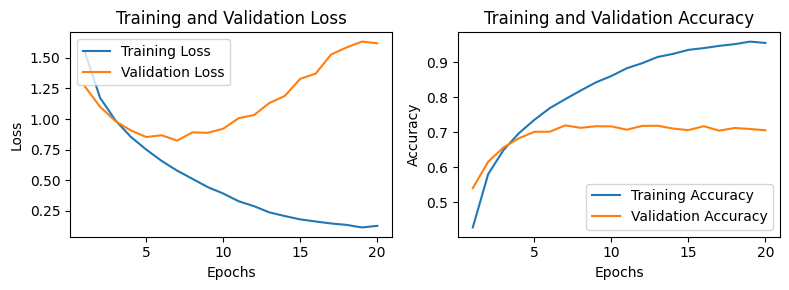

In [57]:
# Apply the function and plot the history
plot_training_history(train_history)

In [58]:
#Load the best model
best_3rd_model = ThirdPartModel()
best_3rd_model.load_state_dict(torch.load('best_3rd_part_model.pth'))
best_3rd_model.to(device)

# Test the best model on the testset
test_loss, test_accuracy = test(
    best_3rd_model, test_loader, criterion, device)

# Print the test performances
print(f"Test Loss: {test_loss:.4f},"
      f"Test Accuracy: {test_accuracy * 100:.2f}%")

Test Loss: 1.6730,Test Accuracy: 70.17%


##### Part3 Summary: In this part I trained the ThirdPart model for 20 epochs. The best model is selected based on validation loss (in 7th epoch). The best model performance is mentioned below.
 -  Train Accuracy: 79.47%
 -  Validaton Accuracy: 71.98%
 -  Test Accuracy: 70.17%

 -  Train Loss: 0.5794
 -  Validation Loss: 0.8243
 -  Test Loss: 1.6730

##### The best model is saved as "best_3rd_part_model.pth"

##### In this part I added more Conv and FC layers. Acctually I used 3 Conv Block. Each Conv block consists of a Conv layer,ReLU activation function, and MaxPooling layer.Also I added a FC layer with ReLU activation function with 256 neurons. This model has more complexity than the basemodel and can extract better features and information from the data.

##### As you see the model performance is better than the baseline model in previous part, from 63.32% to 70.17% in test accuracy.

# Part4

In [59]:
# Improve the Third part model

class ForthPartModel(nn.Module):
    def __init__(self):
        super(ForthPartModel, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=3, out_channels=32, kernel_size=5)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 2 * 2, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        return x

In [60]:
# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model, loss function, and optimizer
forth_part_model = ForthPartModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(forth_part_model.parameters(), lr=0.001)

In [61]:
# Set worst loss for save the best model
best_val_loss = float('inf')
best_epoch = -1

# Save per epochs stats for plot
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Set number of epochs
num_epochs = 20

# Loop through the epochs
for epoch in range(num_epochs):

    # train the model
    train_loss, train_accuracy = train(
        forth_part_model, train_loader, criterion, optimizer, device)

    # validate the model
    val_loss, val_accuracy = validate(
        forth_part_model, val_loader, criterion, device)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Print stats
    print(f"Epoch {epoch + 1}/{num_epochs} || "
          f"Train Loss: {train_loss:.4f}, "
          f"Train Accuracy: {train_accuracy * 100:.2f}%, "
          f"Validation Loss: {val_loss:.4f}, "
          f"Validation Accuracy: {val_accuracy * 100:.2f}%")

    # Save the best model based on validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
        best_model_state = forth_part_model.state_dict()

100%|██████████| 625/625 [00:18<00:00, 33.00it/s]


Epoch 1/20 || Train Loss: 1.2814, Train Accuracy: 53.62%, Validation Loss: 1.0290, Validation Accuracy: 63.09%


100%|██████████| 625/625 [00:13<00:00, 47.42it/s]


Epoch 2/20 || Train Loss: 0.9442, Train Accuracy: 66.66%, Validation Loss: 0.9214, Validation Accuracy: 66.99%


100%|██████████| 625/625 [00:15<00:00, 39.57it/s]


Epoch 3/20 || Train Loss: 0.7851, Train Accuracy: 72.21%, Validation Loss: 0.8100, Validation Accuracy: 71.14%


100%|██████████| 625/625 [00:17<00:00, 36.29it/s]


Epoch 4/20 || Train Loss: 0.6805, Train Accuracy: 75.91%, Validation Loss: 0.7892, Validation Accuracy: 72.29%


100%|██████████| 625/625 [00:13<00:00, 47.10it/s]


Epoch 5/20 || Train Loss: 0.5830, Train Accuracy: 79.52%, Validation Loss: 0.7655, Validation Accuracy: 73.67%


100%|██████████| 625/625 [00:12<00:00, 49.64it/s]


Epoch 6/20 || Train Loss: 0.5144, Train Accuracy: 81.92%, Validation Loss: 0.7562, Validation Accuracy: 74.20%


100%|██████████| 625/625 [00:12<00:00, 48.51it/s]


Epoch 7/20 || Train Loss: 0.4536, Train Accuracy: 84.04%, Validation Loss: 0.8230, Validation Accuracy: 73.04%


100%|██████████| 625/625 [00:12<00:00, 48.67it/s]


Epoch 8/20 || Train Loss: 0.3881, Train Accuracy: 86.28%, Validation Loss: 0.7919, Validation Accuracy: 75.38%


100%|██████████| 625/625 [00:12<00:00, 49.51it/s]


Epoch 9/20 || Train Loss: 0.3428, Train Accuracy: 87.78%, Validation Loss: 0.7956, Validation Accuracy: 75.29%


100%|██████████| 625/625 [00:14<00:00, 44.60it/s]


Epoch 10/20 || Train Loss: 0.2880, Train Accuracy: 89.78%, Validation Loss: 0.8011, Validation Accuracy: 75.43%


100%|██████████| 625/625 [00:12<00:00, 49.06it/s]


Epoch 11/20 || Train Loss: 0.2514, Train Accuracy: 91.14%, Validation Loss: 0.9272, Validation Accuracy: 74.46%


100%|██████████| 625/625 [00:13<00:00, 48.07it/s]


Epoch 12/20 || Train Loss: 0.2246, Train Accuracy: 92.02%, Validation Loss: 0.8917, Validation Accuracy: 75.61%


100%|██████████| 625/625 [00:12<00:00, 49.28it/s]


Epoch 13/20 || Train Loss: 0.1875, Train Accuracy: 93.41%, Validation Loss: 0.9876, Validation Accuracy: 74.09%


100%|██████████| 625/625 [00:12<00:00, 49.66it/s]


Epoch 14/20 || Train Loss: 0.1713, Train Accuracy: 93.86%, Validation Loss: 0.9539, Validation Accuracy: 75.70%


100%|██████████| 625/625 [00:16<00:00, 37.16it/s]


Epoch 15/20 || Train Loss: 0.1604, Train Accuracy: 94.31%, Validation Loss: 1.0577, Validation Accuracy: 74.66%


100%|██████████| 625/625 [00:12<00:00, 49.21it/s]


Epoch 16/20 || Train Loss: 0.1372, Train Accuracy: 95.11%, Validation Loss: 1.0567, Validation Accuracy: 74.99%


100%|██████████| 625/625 [00:12<00:00, 49.41it/s]


Epoch 17/20 || Train Loss: 0.1314, Train Accuracy: 95.36%, Validation Loss: 1.2829, Validation Accuracy: 73.71%


100%|██████████| 625/625 [00:12<00:00, 48.64it/s]


Epoch 18/20 || Train Loss: 0.1184, Train Accuracy: 95.80%, Validation Loss: 1.1907, Validation Accuracy: 74.48%


100%|██████████| 625/625 [00:13<00:00, 45.75it/s]


Epoch 19/20 || Train Loss: 0.1075, Train Accuracy: 96.22%, Validation Loss: 1.2102, Validation Accuracy: 74.26%


100%|██████████| 625/625 [00:12<00:00, 48.67it/s]


Epoch 20/20 || Train Loss: 0.0999, Train Accuracy: 96.51%, Validation Loss: 1.2443, Validation Accuracy: 73.70%


In [62]:
# Save the best model
torch.save(best_model_state, 'best_4th_part_model.pth')
print(f'Best model saved in epoch {best_epoch + 1}')

# Save loss and accuracy values in train_history dict for plot
train_history = {
    'train_loss': train_losses, 'train_accuracy': train_accuracies,
    'val_loss': val_losses, 'val_accuracy': val_accuracies}

Best model saved in epoch 6


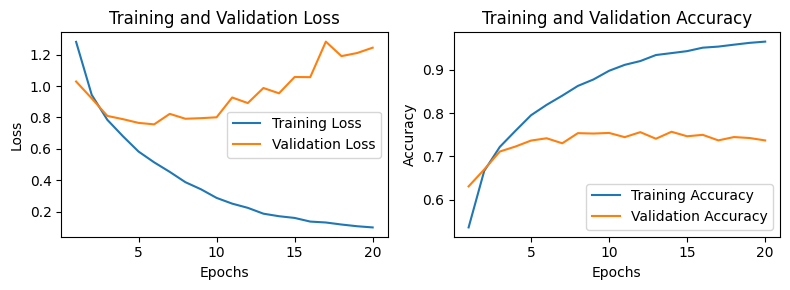

In [63]:
# Apply the function and plot the history
plot_training_history(train_history)

In [64]:
#Load the best model
best_4th_model = ForthPartModel()
best_4th_model.load_state_dict(torch.load('best_4th_part_model.pth'))
best_4th_model.to(device)

# Test the best model on the testset
test_loss, test_accuracy = test(
    best_4th_model, test_loader, criterion, device)

# Print the test performances
print(f"Test Loss: {test_loss:.4f},"
      f"Test Accuracy: {test_accuracy * 100:.2f}%")

Test Loss: 1.2597,Test Accuracy: 73.94%


##### Part4 Summary: In this part I trained the ForthPart model for 20 epochs. The best model is selected based on validation loss (in 6th epoch). The best model performance is mentioned below.
 -  Train Accuracy: 81.92%
 -  Validaton Accuracy: 74.20%
 -   Test Accuracy: 73.94%

 - Train Loss: 0.5144
 -  Validation Loss: 0.7562
 -  Test Loss: 1.2597

##### The best model is saved as "best_4th_part_model.pth"

##### In this part I added BN layer after each Conv block. BN is a regularization method so can prevent overfitting, and also accelerate convergence during training. BN normalizes the input to a layer by subtracting the batch mean and dividing by the batch standard deviation. This is done independently for each feature in the input.The normalized values are then scaled and shifted by learnable parameters (gamma and beta). This allows the model to adapt the normalization to the specific needs of the layer.


##### As you see the model performance is better than the previous part, about 4% improvment in test accuray (from 70.17% to 73.94%).

# Part5

In [67]:
# Improve the Forth Part model
class FifthPartModel(nn.Module):
    def __init__(self):
        super(FifthPartModel, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=3, out_channels=32, kernel_size=5)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 2 * 2, 256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x

In [68]:
# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model, loss function, and optimizer
fifth_part_model = FifthPartModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(fifth_part_model.parameters(), lr=0.001)

In [69]:
# Set worst loss for save the best model
best_val_loss = float('inf')
best_epoch = -1

# Save per epochs stats for plot
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Set number of epochs
num_epochs = 20

# Loop through the epochs
for epoch in range(num_epochs):

    # train the model
    train_loss, train_accuracy = train(
        fifth_part_model, train_loader, criterion, optimizer, device)

    # validate the model
    val_loss, val_accuracy = validate(
        fifth_part_model, val_loader, criterion, device)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Print stats
    print(f"Epoch {epoch + 1}/{num_epochs} || "
          f"Train Loss: {train_loss:.4f}, "
          f"Train Accuracy: {train_accuracy * 100:.2f}%, "
          f"Validation Loss: {val_loss:.4f}, "
          f"Validation Accuracy: {val_accuracy * 100:.2f}%")

    # Save the best model based on validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
        best_model_state = fifth_part_model.state_dict()

100%|██████████| 625/625 [00:12<00:00, 48.17it/s]


Epoch 1/20 || Train Loss: 1.4201, Train Accuracy: 47.94%, Validation Loss: 1.1120, Validation Accuracy: 59.67%


100%|██████████| 625/625 [00:12<00:00, 48.11it/s]


Epoch 2/20 || Train Loss: 1.0728, Train Accuracy: 62.26%, Validation Loss: 0.9891, Validation Accuracy: 65.19%


100%|██████████| 625/625 [00:16<00:00, 37.48it/s]


Epoch 3/20 || Train Loss: 0.9304, Train Accuracy: 67.41%, Validation Loss: 0.8965, Validation Accuracy: 68.12%


100%|██████████| 625/625 [00:18<00:00, 33.84it/s]


Epoch 4/20 || Train Loss: 0.8361, Train Accuracy: 71.02%, Validation Loss: 0.7986, Validation Accuracy: 71.45%


100%|██████████| 625/625 [00:18<00:00, 34.63it/s]


Epoch 5/20 || Train Loss: 0.7621, Train Accuracy: 73.57%, Validation Loss: 0.7618, Validation Accuracy: 72.89%


100%|██████████| 625/625 [00:17<00:00, 35.37it/s]


Epoch 6/20 || Train Loss: 0.7021, Train Accuracy: 75.62%, Validation Loss: 0.7402, Validation Accuracy: 74.40%


100%|██████████| 625/625 [00:15<00:00, 40.17it/s]


Epoch 7/20 || Train Loss: 0.6388, Train Accuracy: 77.73%, Validation Loss: 0.7471, Validation Accuracy: 74.03%


100%|██████████| 625/625 [00:16<00:00, 37.54it/s]


Epoch 8/20 || Train Loss: 0.5974, Train Accuracy: 79.14%, Validation Loss: 0.7218, Validation Accuracy: 75.46%


100%|██████████| 625/625 [00:16<00:00, 37.72it/s]


Epoch 9/20 || Train Loss: 0.5514, Train Accuracy: 80.75%, Validation Loss: 0.7801, Validation Accuracy: 74.46%


100%|██████████| 625/625 [00:19<00:00, 32.38it/s]


Epoch 10/20 || Train Loss: 0.5079, Train Accuracy: 82.14%, Validation Loss: 0.7334, Validation Accuracy: 75.60%


100%|██████████| 625/625 [00:16<00:00, 37.10it/s]


Epoch 11/20 || Train Loss: 0.4752, Train Accuracy: 83.43%, Validation Loss: 0.8082, Validation Accuracy: 73.53%


100%|██████████| 625/625 [00:13<00:00, 45.62it/s]


Epoch 12/20 || Train Loss: 0.4400, Train Accuracy: 84.61%, Validation Loss: 0.7507, Validation Accuracy: 75.74%


100%|██████████| 625/625 [00:13<00:00, 47.59it/s]


Epoch 13/20 || Train Loss: 0.4082, Train Accuracy: 85.39%, Validation Loss: 0.7805, Validation Accuracy: 75.80%


100%|██████████| 625/625 [00:13<00:00, 47.08it/s]


Epoch 14/20 || Train Loss: 0.3832, Train Accuracy: 86.51%, Validation Loss: 0.7430, Validation Accuracy: 76.42%


100%|██████████| 625/625 [00:13<00:00, 44.83it/s]


Epoch 15/20 || Train Loss: 0.3553, Train Accuracy: 87.58%, Validation Loss: 0.8255, Validation Accuracy: 74.59%


100%|██████████| 625/625 [00:12<00:00, 48.65it/s]


Epoch 16/20 || Train Loss: 0.3347, Train Accuracy: 88.21%, Validation Loss: 0.8544, Validation Accuracy: 75.14%


100%|██████████| 625/625 [00:13<00:00, 46.63it/s]


Epoch 17/20 || Train Loss: 0.3095, Train Accuracy: 89.00%, Validation Loss: 0.8198, Validation Accuracy: 76.15%


100%|██████████| 625/625 [00:15<00:00, 40.16it/s]


Epoch 18/20 || Train Loss: 0.2893, Train Accuracy: 89.53%, Validation Loss: 0.8829, Validation Accuracy: 75.63%


100%|██████████| 625/625 [00:13<00:00, 45.12it/s]


Epoch 19/20 || Train Loss: 0.2718, Train Accuracy: 90.30%, Validation Loss: 0.9499, Validation Accuracy: 74.91%


100%|██████████| 625/625 [00:12<00:00, 49.42it/s]


Epoch 20/20 || Train Loss: 0.2574, Train Accuracy: 90.94%, Validation Loss: 0.9170, Validation Accuracy: 75.34%


In [70]:
# Save the best model
torch.save(best_model_state, 'best_5th_part_model.pth')
print(f'Best model saved in epoch {best_epoch + 1}')

# Save loss and accuracy values in train_history dict for plot
train_history = {
    'train_loss': train_losses, 'train_accuracy': train_accuracies,
    'val_loss': val_losses, 'val_accuracy': val_accuracies}

Best model saved in epoch 8


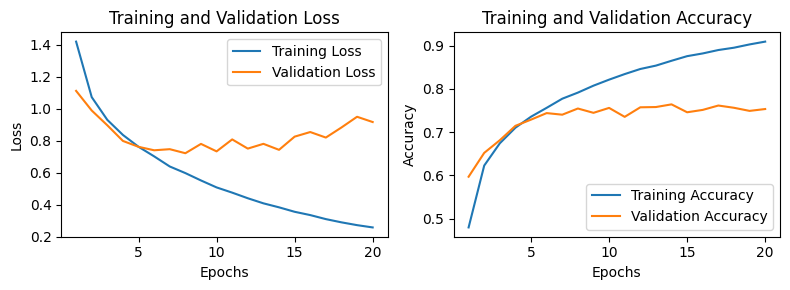

In [71]:
# Apply the function and plot the history
plot_training_history(train_history)

In [72]:
#Load the best model
best_5th_model = FifthPartModel()
best_5th_model.load_state_dict(torch.load('best_5th_part_model.pth'))
best_5th_model.to(device)

# Test the best model on the testset
test_loss, test_accuracy = test(
    best_5th_model, test_loader, criterion, device)

# Print the test performances
print(f"Test Loss: {test_loss:.4f},"
      f"Test Accuracy: {test_accuracy * 100:.2f}%")

Test Loss: 0.9023,Test Accuracy: 75.79%


##### Part5 Summary: In this part I trained the FifthPart model for 20 epochs. The best model is selected based on validation loss (in _th epoch). The best model performance is mentioned below.
 -  Train Accuracy: 79.14%
 -  Validaton Accuracy: 75.46%
 - Test Accuracy: 75.79%

 - Train Loss: 0.5974
 -  Validation Loss: 0.7218
 -  Test Loss: 0.9023

##### The best model is saved as "best_5th_part_model.pth"

##### In this part I add Dropout before the last FC layer. Dropout is a regularization method that helps us to get rid of overfittng. Dropout randomly turns off (setting to zero) a proportion of the neurons during training. This prevents the model from becoming too reliant on specific neurons.

##### This model has highest test accuracy and lowest test loss between all the models in this assignment. The Dropout layer did its work so nicely and improve generalization of the model.

# Part6

### In this part I want to compare the models all togather. First of all I have ran the best model of each part on the testset (1000images) in the previous parts and here I want to just report the whole results and compare the models togather, so lets get starded!
#### In the first part with the base line model I got 63.32% test accuracy, in the 3rd part I added some Conv blocks and a FC layer to make the model more complex and I got 70.17% test accuracy in this part. In 4th and 5th parts I just add BN and Dropout respectively. In 4th part the model test accuracy reached to 73.94% and in 5th part reached to 75.79%. As you see the model performance is increasing.


# Part6 - Confusion Matrix

In [ ]:
# Load the best model of each part

# Best baseline model
best_baseline_model = BaselineModel()
best_baseline_model.load_state_dict(
    torch.load('best_baseline_model.pth'))
best_baseline_model.to(device)

# Best 3th-part model
best_3rd_model = ThirdPartModel()
best_3rd_model.load_state_dict(torch.load('best_3rd_part_model.pth'))
best_3rd_model.to(device)

# Best 4th-part model
best_4th_model = ForthPartModel()
best_4th_model.load_state_dict(torch.load('best_4th_part_model.pth'))
best_4th_model.to(device)

# Best 5th-part model
best_5th_model = FifthPartModel()
best_5th_model.load_state_dict(torch.load('best_5th_part_model.pth'))
best_5th_model.to(device)

In [78]:
# Function to get predictions for the entire test dataset
def get_predictions(model, dataloader, device):
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_preds, all_labels

# Define class names for label of plot
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog',
               'frog', 'horse', 'ship', 'truck']

In [81]:
# A function for calculate and plot confusion matrix
def conf_mat(labels, preds, modelName):

    # Create the confusion matrix
    conf_matrix = confusion_matrix(labels, preds)

    # Plot the confusion matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(
        conf_matrix, annot=True, fmt='d', cmap='Blues',
        xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix {modelName}')
    plt.show()

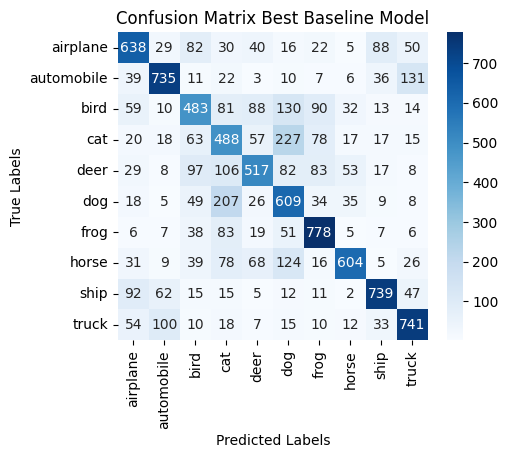

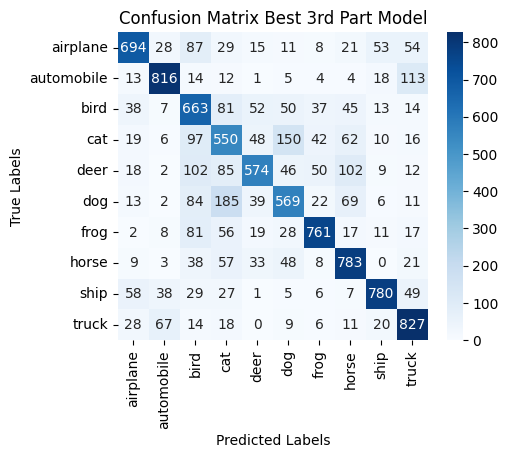

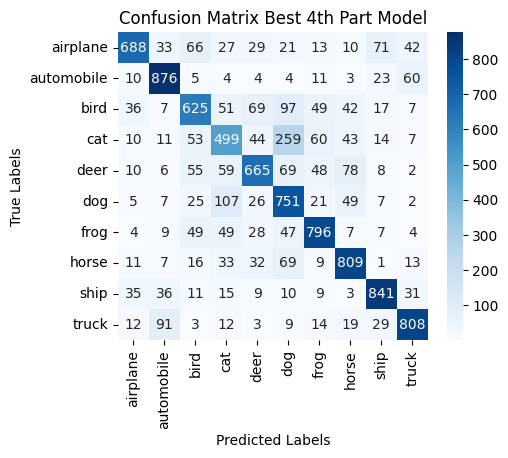

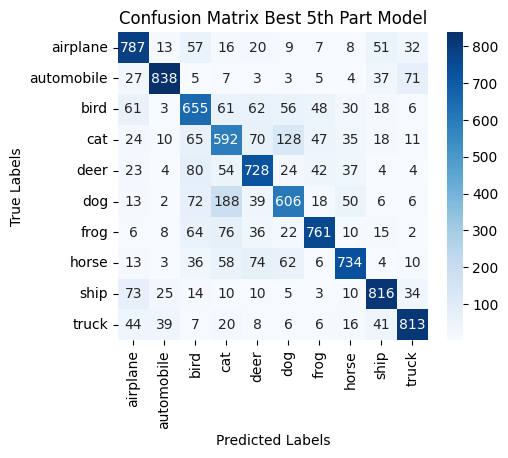

In [82]:
# Get predictions for the entire test dataset
# Base model
preds_base, labels_base = get_predictions(
    best_baseline_model, test_loader, device)

# 3rd model
preds_3rd, labels_3rd = get_predictions(
    best_3rd_model, test_loader, device)

# 4th model
preds_4th, labels_4th = get_predictions(
    best_4th_model, test_loader, device)

# 5th model
preds_5th, labels_5th = get_predictions(
    best_5th_model, test_loader, device)


# Calculate and plot the confusion matrix
conf_mat(labels_base, preds_base, 'Best Baseline Model')
conf_mat(labels_3rd, preds_3rd, 'Best 3rd Part Model')
conf_mat(labels_4th, preds_4th, 'Best 4th Part Model')
conf_mat(labels_5th, preds_5th, 'Best 5th Part Model')
